In [19]:
import os
import re

#os.chdir("/home/s2113174/Projects-1")
os.chdir("d://Projects//Projects-1/")

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from pyDOE import lhs
from scipy.stats import uniform,norm
from scipy.interpolate import griddata

from GaLa_v3 import llaplace

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Taylor Green Vortex

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0 $$

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}+ v\frac{\partial u}{\partial y} = - \frac{1}{\rho}\frac{\partial p}{\partial x} + \nu (\frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} v}{\partial y^{2}})$$

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}+ v\frac{\partial u}{\partial y} = - \frac{1}{\rho}\frac{\partial p}{\partial y} + \nu (\frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} v}{\partial y^{2}})$$



where $0 \leq x,y \leq \pi$ and boundary conditions
$$u(x,0) = sin( x)e^{-2 \nu t}, u(x,\pi) = -sin( x)e^{-2 \nu t}$$
$$u(0,y) = u(\pi,y) =0 $$


$$v(0,y) = -sin( y)e^{-2 \nu t}, v(\pi,y) = -sin(y)e^{-2 \nu t}$$
$$v(x,0) = u(x,\pi) =0 $$

This equation has the following analytical solution.

$$u(x,y,t)= sin(x)cos(y)e^{-2 \nu t}$$
$$v(x,y,t)= -cos(x)sin(y)e^{-2 \nu t}$$

In [20]:
def exact_sol(x,y,t,nu):
    u = np.sin(x)*np.cos(y)*np.exp(-2*nu*t)
    v = -np.cos(x)*np.sin(y)*np.exp(-2*nu*t)
    return u, v

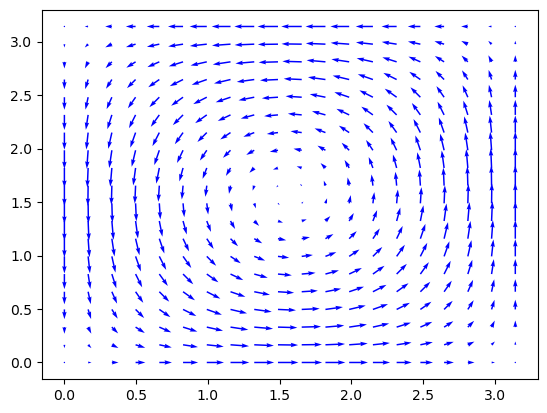

Text(0.5, 0, 'x')

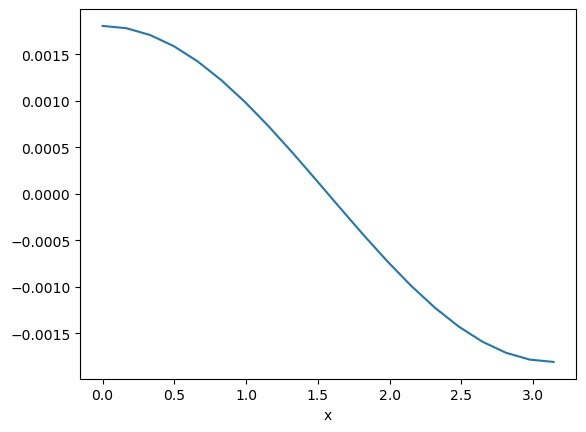

In [21]:
x = np.linspace(0,1,20)*np.pi
y = np.linspace(0,1,20)*np.pi
t = np.linspace(0,100,100)
nu = 1/16

xx, yy, tt = np.meshgrid(x, y,t)

fig,ax = plt.subplots()

u,v = exact_sol(xx[:,:,0],yy[:,:,0],tt[:,:,50],nu)
img = ax.quiver(x, y, u, v, color='blue') 
plt.show()
plt.plot(x,u[:,9])
plt.xlabel("x")
# def animate(i):
#     ax.clear()
#     ax.set_title(f"Observations at time = {i+1}")
#     ax.set_xlabel("x")
#     ax.set_ylabel(fr"u(x,t={i+1})")

#     u,v = exact_sol(xx,yy,t[i],nu)

#     img = ax.quiver(x, y, u, v, color='blue') 

#     return img

# ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=100)    
# ani.save("TGV_exact.gif", dpi=300, writer=PillowWriter(fps=25))

## Feed Forward Neural Network

In [22]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric Neural PDE

In [23]:
def de(self,data_domain, ro = 1):
    """ The pytorch autograd version of calculating residual """
    f = self(data_domain)
    
    du = torch.autograd.grad(
        f[:,0], data_domain, 
        grad_outputs=torch.ones_like(f[:,0]),
        retain_graph=True,
        create_graph=True
    )[0]

    dv = torch.autograd.grad(
        f[:,1], data_domain, 
        grad_outputs=torch.ones_like(f[:,1]),
        retain_graph=True,
        create_graph=True
    )[0]

    dp = torch.autograd.grad(
        f[:,2], data_domain, 
        grad_outputs=torch.ones_like(f[:,2]),
        retain_graph=True,
        create_graph=True
    )[0]
    
    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddu_y = torch.autograd.grad(
        du[:,1],data_domain, 
        grad_outputs=torch.ones_like(du[:,1]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddv_x = torch.autograd.grad(
        dv[:,0],data_domain, 
        grad_outputs=torch.ones_like(dv[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddv_y = torch.autograd.grad(
        dv[:,1],data_domain, 
        grad_outputs=torch.ones_like(dv[:,1]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    r = du[:,0].reshape(-1,1) + dv[:,1].reshape(-1,1)
    g = du[:,2].reshape(-1,1) + f[:,0].reshape(-1,1) *du[:,0].reshape(-1,1) + f[:,1].reshape(-1,1)*du[:,1].reshape(-1,1) +\
                (1/ro)*dp[:,0].reshape(-1,1) - data_domain[:,-1].reshape(-1,1)*(ddu_x[:,0].reshape(-1,1) + ddu_y[:,1].reshape(-1,1))
    
    h = dv[:,2].reshape(-1,1) + f[:,0].reshape(-1,1)*dv[:,0].reshape(-1,1) + f[:,1].reshape(-1,1)*dv[:,1].reshape(-1,1) +\
                (1/ro)*dp[:,1].reshape(-1,1) - data_domain[:,-1].reshape(-1,1)*(ddv_x[:,0].reshape(-1,1) + ddv_y[:,1].reshape(-1,1))
    return torch.cat([r,g,h],axis = 1)

def down_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,0].reshape(-1,1) - torch.sin(data_inic[:,0].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*torch.cos(2*data_inic[:,0].reshape(-1,1))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([bc1,f[:,1].reshape(-1,1),bc3],axis = 1)

def up_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,0].reshape(-1,1) + torch.sin(data_inic[:,0].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*torch.cos(2*data_inic[:,0].reshape(-1,1))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([bc1,f[:,1].reshape(-1,1),bc3],axis = 1)

def left_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,1].reshape(-1,1) + torch.sin(data_inic[:,1].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*(1+torch.sin(2*data_inic[:,1].reshape(-1,1)))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([f[:,0].reshape(-1,1),bc1,bc3],axis = 1)

def right_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,1].reshape(-1,1) - torch.sin(data_inic[:,1].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*(1+torch.sin(2*data_inic[:,1].reshape(-1,1)))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([f[:,0].reshape(-1,1),bc1,bc3],axis = 1)

In [24]:
DNN.de = de
DNN.down_bc = down_bc
DNN.up_bc = up_bc
DNN.left_bc = left_bc
DNN.right_bc = right_bc

In [25]:
def samples_space(size = 10,maxl = np.pi):
    xyt = lhs(3, size)
    xyt[:,:2] = xyt[:,:2]*maxl
    xyt[:,-1] = xyt[:,-1]*10
    return xyt

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [26]:
def data_pde(size,minp,maxp):

    xyt, param = samples_space(size),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xyt,param.reshape(-1,1)))).float()
    
    x,y,t = torch.tensor(xyt[:,0]).reshape(-1,1),torch.tensor(xyt[:,1]).reshape(-1,1),torch.tensor(xyt[:,2]).reshape(-1,1)
    param = torch.tensor(param).reshape(-1,1)
    
    down_bc = torch.cat([x,torch.zeros_like(x).float(),t, param],axis = 1).float()

    up_bc = torch.cat([x,torch.ones_like(x).float()*(torch.pi),t, param],axis = 1).float()

    left_bc = torch.cat([torch.zeros_like(y).float(),y,t, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(y).float()*(torch.pi),y,t, param],axis = 1).float()

    return pde_domain,down_bc,up_bc,left_bc,right_bc

In [27]:
def train_adam(pinn,loss,optimizer,epochs, sample_size = 100,minval_param = 0.2,maxval_param = 2,repetitions=1):
      print("Starting Adam Training")
      train_loss=[]
      
      for i in range(epochs):
        pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
        pde_domain,down_bc,up_bc,left_bc,right_bc = pde_domain.to(device),down_bc.to(device),up_bc.to(device),left_bc.to(device),right_bc.to(device)

        pde_domain = Variable(pde_domain,requires_grad=True)
        down_bc,up_bc = Variable(down_bc,requires_grad=True),Variable(up_bc,requires_grad=True)
        left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
        
        for _ in range(repetitions):
                optimizer.zero_grad()

                pde_pred  = pinn.de(pde_domain)
                down_bc_pred,up_bc_pred = pinn.down_bc(down_bc),pinn.up_bc(up_bc)
                left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

                zeros = torch.zeros_like(pde_pred)

                loss_pde = loss(pde_pred,zeros)
                loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
                loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

                Loss =  3*(loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc)
                
                train_loss.append(Loss.item())

                if i % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                 Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item()))      
                Loss.backward() 

                optimizer.step() 
                
      return train_loss

In [28]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100,minval_param = 0.2,maxval_param = 2):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
    pde_domain,down_bc,up_bc,left_bc,right_bc = pde_domain.to(device),down_bc.to(device),up_bc.to(device),left_bc.to(device),right_bc.to(device)

    pde_domain = Variable(pde_domain,requires_grad=True)
    down_bc,up_bc = Variable(down_bc,requires_grad=True),Variable(up_bc,requires_grad=True)
    left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
    

    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred  = pinn.de(pde_domain)
        down_bc_pred,up_bc_pred = pinn.down_bc(down_bc),pinn.up_bc(up_bc)
        left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

        zeros = torch.zeros_like(pde_pred)

        loss_pde = loss(pde_pred,zeros)
        loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
        loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

        Loss =  3*(loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc)
        
        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                        Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item())) 
        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [29]:
# Number of observations
epochs = 5000
nobs = 1000
lr = 0.01

min_param , max_param = 0.0001, 0.05

layers = [4] + 4*[80] + [3]

model = DNN(layers).to(device)

In [30]:
# loss = torch.nn.MSELoss(reduction ='mean')

# optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# loss_history = train_adam(model,loss,optimizer,epochs, nobs,min_param,max_param)

# optimizer = torch.optim.LBFGS(model.parameters(), 
#     lr=lr, max_iter=50000, max_eval=None, 
#     tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,
#     line_search_fn="strong_wolfe" 
#     )

# loss_history_b = train_LBFGS(model,loss,optimizer, nobs*2,min_param,max_param)

In [31]:
path = "../Projects-1/Physics _Informed_NN/GaLA/Gala_models/Taylor_Green.pt"
#torch.save(model.state_dict(),path)
model.load_state_dict(torch.load(path))
model.eval()

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=4, out_features=80, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=80, out_features=80, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=80, out_features=80, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=80, out_features=80, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=80, out_features=3, bias=True)
  )
)

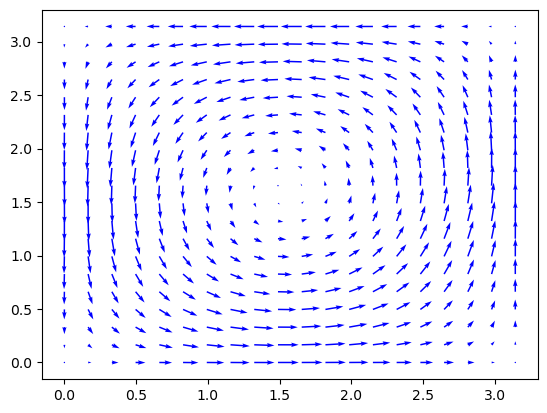

Text(0.5, 0, 'x')

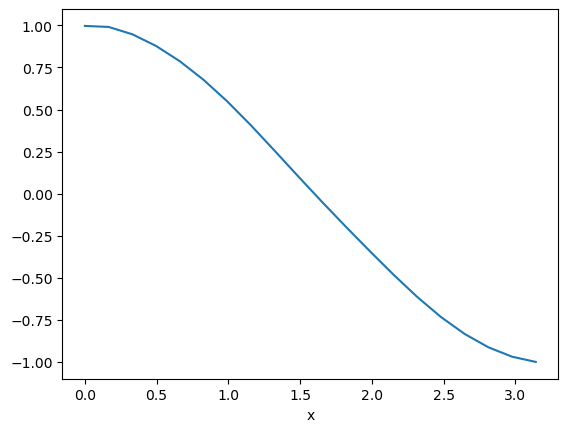

In [32]:
x = np.linspace(0,1,20)*np.pi
y = np.linspace(0,1,20)*np.pi
t = np.linspace(0,2,10)
nu = 1/100

xx, yy = np.meshgrid(x, y)

xx, yy = torch.tensor(xx).reshape(-1,1).float().to(device),torch.tensor(yy).reshape(-1,1).float().to(device)

X_star = torch.cat([xx,yy,torch.ones_like(xx).to(device)*(t[0]),torch.ones_like(xx).to(device)*(nu)],axis = 1)

f = model(X_star)

xx, yy = np.meshgrid(x, y)

u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f[:,0].cpu().detach().numpy().flatten(), (xx,yy), method='cubic')
v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f[:,1].cpu().detach().numpy().flatten(), (xx,yy), method='cubic')

plt.quiver(x, y, u, v, color='blue') 
plt.show()
plt.plot(x,u[:,9])
plt.xlabel("x")

In [46]:
pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(1,min_param,max_param)

pde = {"PDE":["de","down_bc","up_bc","left_bc","right_bc"], 
       "data_set":{"de" : Variable(pde_domain.to(device),requires_grad=True),
                   "down_bc":down_bc.to(device),
                   "up_bc":up_bc.to(device),
                   "left_bc":left_bc.to(device),
                   "right_bc" :right_bc.to(device)}}

llp = llaplace(model,sigma_noise=1, prior_precision=1)
llp.fit(pde=pde, hessian_structure = "full")

# log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
# hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
# for i in range(1000):
#     hyper_optimizer.zero_grad()
#     neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
#     neg_marglik.backward(retain_graph=True)
#     hyper_optimizer.step()
#     print(log_prior,log_sigma)

torch.Size([243, 243])
torch.Size([1, 83])


RuntimeError: The size of tensor a (243) must match the size of tensor b (83) at non-singleton dimension 1

In [54]:
llp.model._features

{'layers.layer_4': tensor([[ 0.5918, -0.2182, -0.5122, -0.7068, -0.7340,  0.1467, -0.5322,  0.2884,
          -0.2709,  0.9029, -0.5424,  0.9942,  0.1778, -0.3092, -0.6900,  0.2261,
          -0.5540, -0.9576, -0.9731,  0.6647,  0.7642, -0.9759,  0.9825, -0.9987,
           0.4507,  0.2916,  0.8022, -0.3769, -0.8549,  0.3152, -0.6669,  0.7123,
          -0.5523,  0.5324, -0.9870,  0.6665, -0.6070, -0.7020,  0.6104,  0.5973,
          -0.5949,  0.9464,  0.3581, -0.0235,  0.8676, -0.1882, -0.9796,  0.7125,
          -0.1406,  0.3641,  0.2911, -0.9973,  0.8690,  0.2034,  0.2232,  0.5217,
          -0.1895, -0.3044,  0.9349,  0.5393, -0.9981, -0.0228,  0.5254, -0.5467,
          -0.3058,  0.9820, -0.8033,  0.9665, -0.7860, -0.7219,  0.5318,  0.2174,
           0.0433,  0.4447, -0.8512, -0.1558,  0.9889, -0.9711,  0.1211, -0.9976]],
        device='cuda:0')}

In [51]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

layers.layer_0.weight tensor([[ 1.8175e-01,  1.8667e-01,  1.2932e-03,  3.5604e+00],
        [ 2.6252e-01, -1.2555e-01, -1.1757e-02, -2.0589e-01],
        [ 2.0917e-01,  3.7577e-01, -8.0563e-02, -3.5318e+00],
        [-1.7275e+00,  7.7688e-02, -1.8107e-02, -3.0304e+00],
        [ 2.4084e-01,  2.4691e-01,  5.2621e-03,  2.3450e+00],
        [ 3.4793e-01,  2.1296e-01, -3.2121e-02, -2.9955e-01],
        [ 1.5964e-01,  2.0967e-01,  5.8612e-02, -1.5350e+00],
        [-2.1979e-01,  1.3403e-02,  7.6920e-02,  2.7517e+00],
        [ 2.6485e-01,  1.9783e-01, -7.1717e-03,  4.8080e+00],
        [ 5.6517e-02, -1.5076e-01,  1.0797e-01, -6.1928e-02],
        [-5.2757e-01, -2.6062e-01,  6.6269e-02,  1.6872e+00],
        [-4.4312e-01,  5.4710e-01,  4.1617e-01, -9.3440e-01],
        [ 4.8990e-01, -1.8959e+00, -4.1214e-02,  4.4427e-01],
        [ 2.4971e-01,  3.9756e-01,  7.4753e-03, -2.5794e+00],
        [ 2.2601e-01,  2.4978e-01,  1.8304e-02, -2.0468e+00],
        [-7.0715e-01,  5.9297e-01, -2.1691e-02, 

In [72]:
import scipy.io

data = scipy.io.loadmat('../Projects-1/Physics _Informed_NN/Pytorch/burgers_shock.mat')
y = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

Exact = np.real(data['usol']).T

xx, yy = np.meshgrid(x, y)

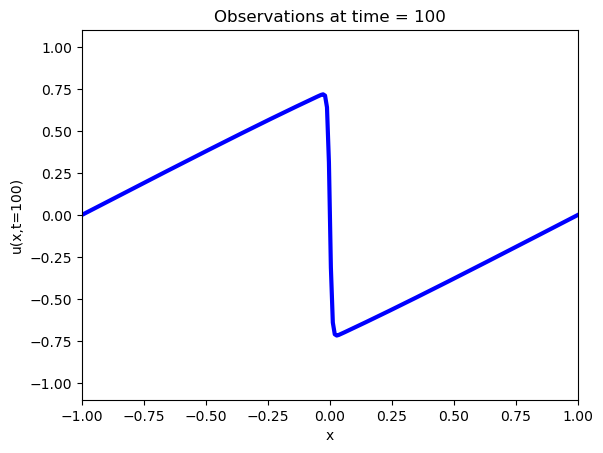

In [73]:
# from matplotlib.animation import FuncAnimation, PillowWriter
# fig,ax = plt.subplots()

# def animate(i):
#     ax.clear()
#     ax.set_title(f"Observations at time = {i+1}")
#     ax.set_xlabel("x")
#     ax.set_ylabel(fr"u(x,t={i+1})")
#     ax.set_ylim((-1.1,1.1))
#     ax.set_xlim((-1,1))
#     img = ax.plot(x,Exact[i,:],color = "blue", linewidth = 3)

#     return img

# ani = FuncAnimation(fig, animate, interval=5, blit=True, repeat=True, frames=100)    
# ani.save("TLI.gif", dpi=300, writer=PillowWriter(fps=25))

In [39]:
from scipy.interpolate import griddata

x,t = np.linspace(-1,1,250),np.linspace(0,1.5,250)

xx, yy = np.meshgrid(x, t)
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

X_star1 = torch.cat([xx,yy,torch.ones_like(xx)*(0.01/np.pi)],axis = 1)
X_star2 = torch.cat([xx,yy,torch.ones_like(xx)*(0.06)],axis = 1)

xx, yy = np.meshgrid(x, t)

f_mu1, f_sigma1 = llp(X_star1)
f_mu1, f_sigma1 = f_mu1.cpu().numpy(), f_sigma1.squeeze().sqrt().cpu().numpy().reshape(-1,1)

z_pred1 = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu1.flatten(), (xx,yy), method='cubic')
z_pred_var1 = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma1.flatten(), (xx,yy), method='cubic')

f_mu2, f_sigma2 = llp(X_star2)
f_mu2, f_sigma2 = f_mu2.cpu().numpy(), f_sigma2.squeeze().sqrt().cpu().numpy().reshape(-1,1)

z_pred2 = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu2.flatten(), (xx,yy), method='cubic')
z_pred_var2 = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma2.flatten(), (xx,yy), method='cubic')

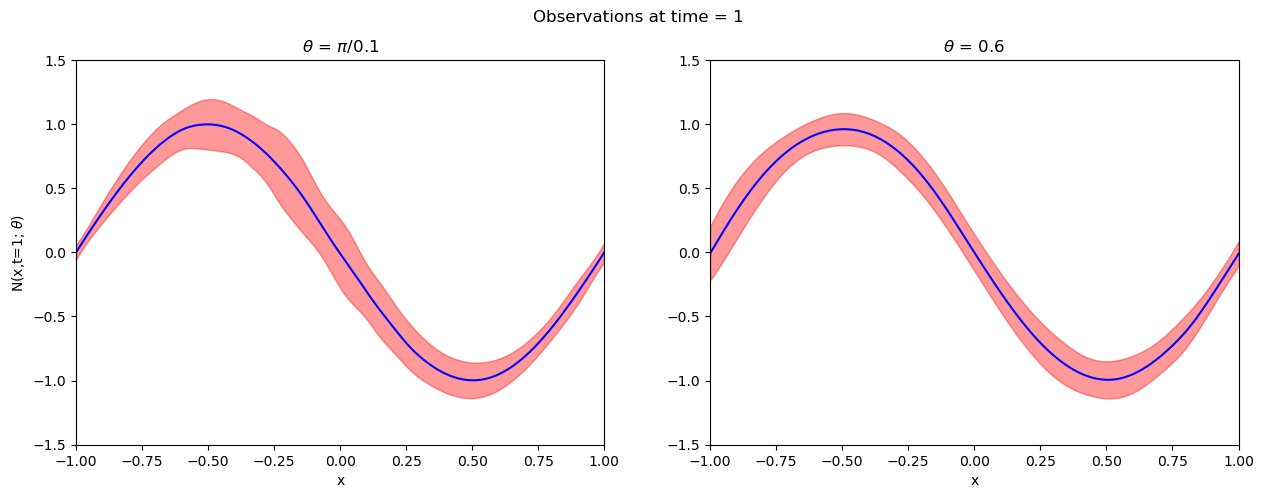

In [61]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig,ax = plt.subplots(1,2,figsize=(15,5))

def animate(i):
    if i > 166:
        plt.suptitle(f"Observations at time = {i+1}", color = "red")
    else:
        plt.suptitle(f"Observations at time = {i+1}")

    ax[0].clear()
    ax[1].clear()

    ax[0].set_title(fr"$\theta$ = $\pi/0.1$")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel(fr"N(x,t={i+1}; $\theta$)")
    ax[0].set_ylim((-1.5,1.5))
    ax[0].set_xlim((-1,1))

    ax[1].set_title(fr"$\theta$ = 0.6")
    ax[1].set_xlabel("x")
    ax[1].set_ylim((-1.5,1.5))
    ax[1].set_xlim((-1,1))

    img1 = ax[0].plot(x,z_pred1[i,:],color = "blue")
    img2 = ax[0].fill_between(x.reshape(-1), z_pred1[i,:]+2*z_pred_var1[i,:],z_pred1[i,:]-2*z_pred_var1[i,:],alpha=0.4, color = "red")

    img3 = ax[1].plot(x,z_pred2[i,:],color = "blue")
    img4 = ax[1].fill_between(x.reshape(-1), z_pred2[i,:]+2*z_pred_var2[i,:],z_pred2[i,:]-2*z_pred_var2[i,:],alpha=0.4, color = "red")

    return img1,img2,img3,img4

ani = FuncAnimation(fig, animate, interval=5, blit=False, repeat=True, frames=250)    
ani.save("TLIb.gif", dpi=300, writer=PillowWriter(fps=25))

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
fig,ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.set_title(f"Observations at time = {i+1}")
    ax.set_xlabel("x")
    ax.set_ylabel(fr"u(x,t={i+1})")
    ax.set_ylim((-1.1,1.1))
    ax.set_xlim((-1,1))
    img = ax.plot(x,Exact[i,:],color = "blue", linewidth = 3)

    return img

ani = FuncAnimation(fig, animate, interval=40, blit=True, repeat=True, frames=100)    
ani.save("TLI.gif", dpi=300, writer=PillowWriter(fps=25))




In [60]:
param_trained =  samples_param(min_param , max_param,6)
from scipy.interpolate import griddata


# Plotting
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.25)

for n,pr in enumerate(param_trained):
    
    xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

    X_star = torch.cat([xx,yy,torch.ones_like(xx)*pr],axis = 1)

    u_pred = model(X_star).detach().cpu().numpy()

    f_mu, f_sigma = llp(X_star)

    f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy().reshape(-1,1)
    
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = Exact
    
    plt.subplot(8, 2, n + 1)

    plt.plot(x,z_pred[-1,:],color = "blue")
    plt.fill_between(x.reshape(-1), z_pred[-1,:]+2*z_pred_var[-1,:],z_pred[-1,:]-2*z_pred_var[-1,:],alpha=0.4, color = "red")
    plt.plot(x,z_exact[-1,:],linestyle = "--",color = "black")

    plt.xlabel("x")
    plt.ylabel(r'u(x,t)')
    #plt.legend(frameon=False)

NameError: name 'xx' is not defined

<Figure size 2500x2500 with 0 Axes>

## MCMC Step

In [76]:
def log_prior_alpha(alpha): #function to evaluate prior pdf of given parameters
    return norm.logpdf(alpha,loc = 0,scale = 1.5)

def proposals(alpha,dt):
    return np.random.normal(alpha,dt)

In [125]:
def log_likelihood_marginal(surrogate,alpha,xx,yy,y_dat,sig = 0.0001):

    X_star = torch.cat([xx,yy,torch.ones_like(xx)*alpha],axis = 1)

    surg_mu, surg_sigma = surrogate(X_star.float())
    surg_mu, surg_sigma = surg_mu.to(torch.float64).cpu().numpy().reshape(-1),surg_sigma.to(torch.float64).squeeze().cpu().numpy()
    #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    #return np.sum(- ((y_dat-surg_mu)**2) / (2*(sig**2+surg_sigma))) - (0.5)*np.sum(np.log(sig**2+surg_sigma)) -  y_dat.shape[0]*(0.5)*np.log(2*np.pi) 
    return np.sum(- ((y_dat-surg_mu)**2) / (2*(sig**2+surg_sigma)))

# def log_likelihood(surrogate,alpha,t,y_dat,sig = 0.0001):
    
#     data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(alpha)))

#     surg = surrogate(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)
        
#     #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    return np.sum(- ((y_dat-surg)**2) / (2*sig**2))

# def log_likelihood_ex(alpha,t,y,sig = 0.0001):

#     surg_exact = (t - t**2) / (2*np.exp(alpha))

#     #return np.sum(-np.log(np.sqrt(2* np.pi*sig**2)) - ((y-surg_exact)**2) / (2*sig**2))
#     return np.sum(-((y-surg_exact)**2) / (2*sig**2))

In [126]:
# def log_posterior_ex(alpha,t,y):
#     return  log_likelihood_ex(alpha,t,y) + log_prior_alpha(alpha)

def log_posterior_nn_marginal(model,alpha,xx,yy,y):
    return  log_likelihood_marginal(model,alpha,xx,yy,y) + log_prior_alpha(alpha)
#    return  log_likelihood(model,alpha,t,y) 

# def log_posterior_nn(model,alpha,t,y):
#     return  log_likelihood(model,alpha,t,y) + log_prior_alpha(alpha)

In [64]:
# theta_h = 0.314
# t, noise_sol_test = test_set(ns,1000,theta_h,mean,std)

In [65]:
# data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(0.5)))

# surg_mu, surg_sigma = llp(torch.tensor(data_).float())
# surg_mu, surg_sigma = surg_mu.cpu().numpy().reshape(-1),surg_sigma.squeeze().cpu().numpy()

# print(np.sum(- ((noise_sol_test-surg_mu)**2) / (2*(std**2+surg_sigma))))

# #np.sum(- ((y_dat-surg_mu)**2) / (2*(sig**2+surg_sigma))) - (0.5)*np.sum(np.log(sig**2+surg_sigma)) -  y_dat.shape[0]*(0.5)*np.log(2*np.pi) 


In [127]:
alpha_ = np.linspace(-1,1,2000)

alpha_fc,alpha_fc_2,alpha_fc_3 = [],[],[]
alpha_fc_nn,alpha_fc_2_nn,alpha_fc_3_nn = [],[],[]
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

for alp in alpha_:
    # alpha_fc_nn.append(log_posterior_nn_marginal(llp,alp,t[:50],Exact.flatten()[:50]))
    
    # alpha_fc_2_nn.append(log_posterior_nn_marginal(llp,alp,t[:500],Exact.flatten()[:500]))
    
    alpha_fc_3_nn.append(log_posterior_nn_marginal(llp,alp,xx,yy,Exact.flatten()))

/tmp/ipykernel_22858/3999609544.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()


In [128]:
np.exp(alpha_fc_3_nn)

array([0., 0., 0., ..., 0., 0., 0.])

/tmp/ipykernel_22858/3514667346.py:18: RuntimeWarning: invalid value encountered in divide
  plt.plot(alpha_,200*np.exp(alpha_fc_3_nn)/np.sum(np.exp(alpha_fc_3_nn)), label = "all obs")


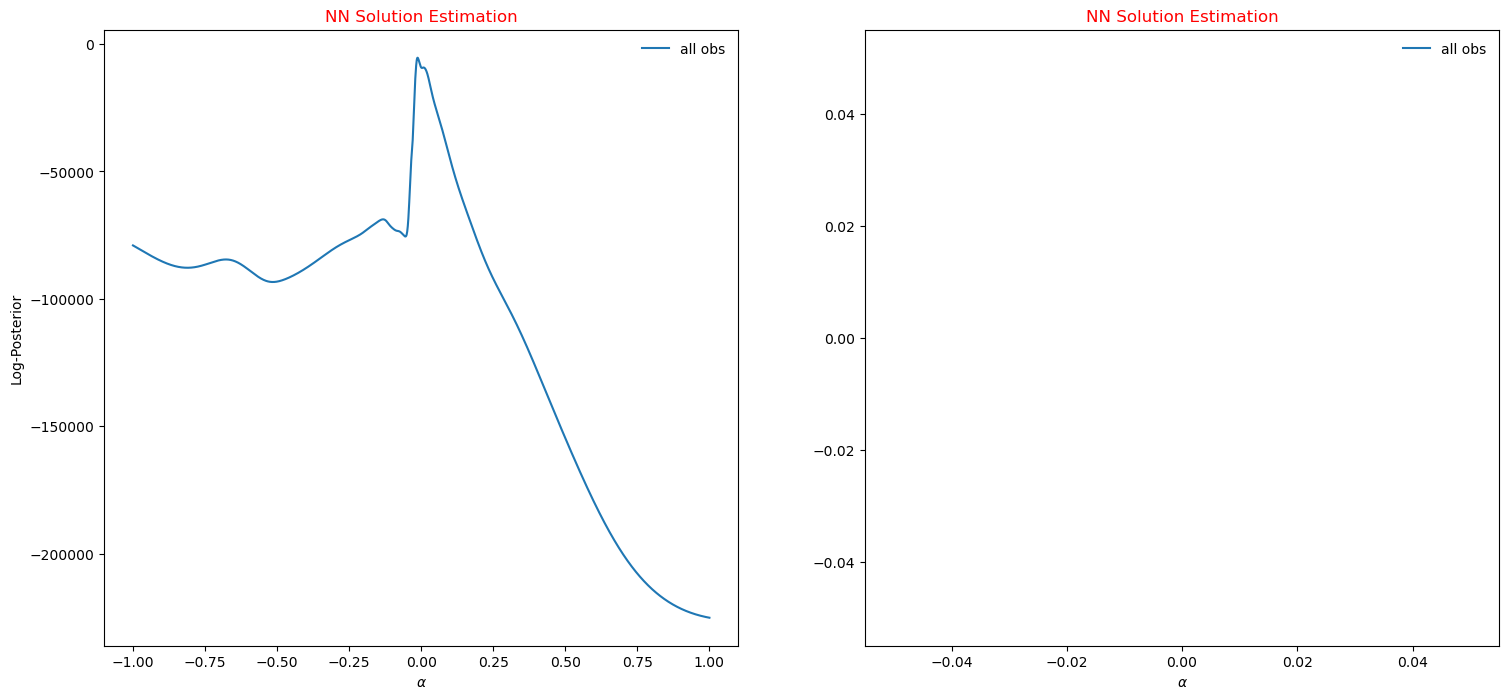

In [129]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=0.25)


plt.subplot(1, 2, 1)
plt.plot(alpha_,alpha_fc_3_nn, label = "all obs")

#plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("NN Solution Estimation",color = "red")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)



plt.subplot(1,2 , 2)
plt.plot(alpha_,200*np.exp(alpha_fc_3_nn)/np.sum(np.exp(alpha_fc_3_nn)), label = "all obs")

#plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("NN Solution Estimation",color = "red")
plt.xlabel(r"$\alpha$")
#plt.xlim(0,0.5)
plt.legend(frameon =False)

In [72]:
def Metropolis_Hastings_marginal(y_dat,nChains):

    alpha = 0.5

    alpha_samp = []
    acceptance_rate, dt = 0, 0.5

    dt_tracker = []
    for i in range(nChains):

        log_posterior =  log_posterior_nn_marginal(llp,alpha,y_dat)
        #log_posterior = log_posterior_ex(alpha,t,y_dat)

        alpha_proposal = proposals(alpha,dt)

        log_posterior_proposal = log_posterior_nn_marginal(llp,alpha_proposal,y_dat)
        #log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat)

        accept_u = np.random.uniform(0,1)

        ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)

        a = np.min([1.,ratio])

        if accept_u < a:
            alpha = alpha_proposal
            acceptance_rate += 1
        
        dt = dt + dt*(a - 0.234)/ (i+1) 
        dt_tracker.append(dt)
        alpha_samp.append(alpha)


    print(f"Acceptance Rate: {acceptance_rate/nChains:.3f}")

    return alpha_samp,dt_tracker

In [69]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

In [ ]:
data = scipy.io.loadmat('../Projects-1/Physics _Informed_NN/Pytorch/burgers_shock.mat')

y = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

Exact = np.real(data['usol']).T

xx, yy = np.meshgrid(x, y)

xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

In [73]:
alpha_samp_marginal,dt_tracker_marginal = Metropolis_Hastings_marginal(Exact.flatten(),100000)

/tmp/ipykernel_22858/3094543993.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  surg_mu, surg_sigma = surrogate(torch.tensor(X_star).float())
/tmp/ipykernel_22858/1286672319.py:21: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)


Acceptance Rate: 0.001


Text(0.5, 0, 'Iteration')

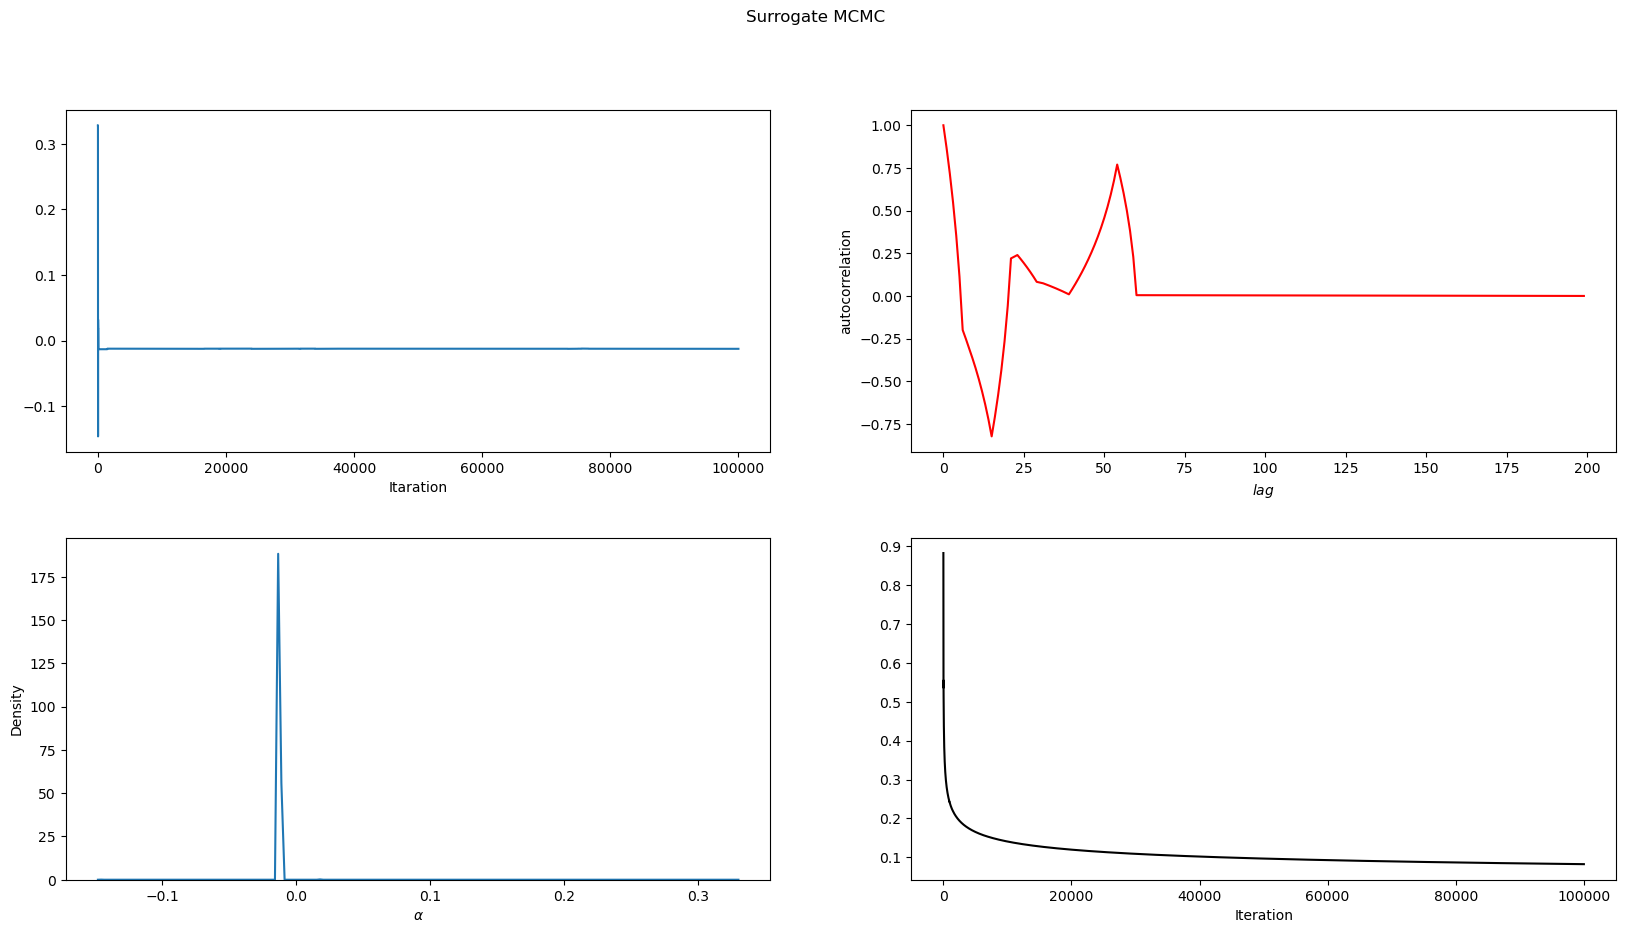

In [74]:
import seaborn as sns

fig = plt.figure(figsize=(20,10))
plt.suptitle("Surrogate MCMC")
plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp_marginal)
plt.xlabel("Itaration")
#plt.ylim(0.3,0.35)

plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp_marginal,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
#plt.hist(alpha_samp[200:],color = "orange",alpha = 0.5)
#plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")
sns.kdeplot(alpha_samp_marginal,bw_adjust=2)
plt.xlabel(r"$\alpha$")
#plt.xlim(0.3,0.32)

plt.subplot(2, 2, 4)
plt.plot(dt_tracker_marginal,color = "black")
plt.xlabel("Iteration")